# Assignment: Counterfeit Banknotes - Classification

KATE expects your code to define variables with specific names that correspond to certain things we are interested in.

KATE will run your notebook from top to bottom and check the latest value of those variables, so make sure you don't overwrite them.

* Remember to uncomment the line assigning the variable to your answer and don't change the variable or function names.
* Use copies of the original or previous DataFrames to make sure you do not overwrite them by mistake.

You will find instructions below about how to define each variable.

Once you're happy with your code, upload your notebook to KATE to check your feedback.

## About the assignment

This assignment is designed to go through the basic principles of handling a Supervised Learning problem. The main task is to build a classification model to accurately distinguish between genuine and counterfeit banknotes.

A vital part of any supervised learning model is the validation step. In this assignment, we will go through splitting the data into training/testing sets and using *k-fold* cross-validation to tune the parameters of a Decision Tree classifier. The last step is to check the performance of our classifier using *accuracy* as a metric, construct the *ROC* curve and calculate the *AUC* metric.

The implementation will be done using the `sklearn` package, which contains all the necessary tools for model training, validation, metrics etc.

Please be sure to **use the variable names as specified** in this notebook.

## About the data

The dataset for this assignment concerns the classification of banknotes as counterfeit or not. The special printing technique that is applied to banknotes adds a unique structure to the surface of the notes. The result of this unique printing process, is that it can be used as a way to check for authenticity.

The dataset examined in this assignment is extracted from images that were taken from genuine and counterfeit banknotes using an industrial camera. The next step in the creation of the data, is the application of a frequency transformation. This way it is possible to split lower and higher frequencies, determine spectral components and analyze them. This dataset uses the *Wavelet Transformation* (WT). After some data pre-processing and cleaning, the final result contains the object-specific features from the wavelet coefficients. 

There are 4 features in this dataset which represent the variance, skewness and kurtosis of the transformed image as well as the entropy of the image. The target variable is the class of the notes. 

## Setup

First, let's load all the necessary libraries needed for this assignment

In [1]:
# Import numpy and pandas for data manipulation
import numpy as np 
import pandas as pd
# Import matplotlib for generating the plots
import matplotlib.pyplot as plt
import seaborn as sns

# Import the necessary sklearn methods

# Model selection methods for cross-validation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
# Method for feature scaling
from sklearn.preprocessing import MinMaxScaler
# Decision tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Classification metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import auc,roc_curve

/var/folders/00/h4l_zl594z1g4kp3qw9d3bdc0000gn/T/ipykernel_59079/3667823823.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data

In this assignment we will load two datasets. The first one contains the data needed for training our model (let's save it to a variable called `df`). The second one contains the data needed for evaluating our model with **KATE**. This will be our held-out test data (let's save it to a variable called `df_eval`).

We will need to process `df_eval` in exactly the same way as `df`, train our model on `df` and make predictions using `df_eval`.

Run the followng cell to load the data

In [2]:
df = pd.read_csv('data/banknote.csv')
df_eval = pd.read_csv('data/banknote_eval.csv')

print(df.shape)
print(df_eval.shape)

(1097, 5)
(275, 5)


In [3]:
df_eval.head()

,variance_image,skewness_image,kurtosis_image,entropy_image,class
0,-1.56210,-2.2121,4.25910,0.27972,NaN
1,2.55590,3.3605,2.03210,0.26809,NaN
2,-2.31470,3.6668,-0.69690,-1.24740,NaN
3,2.96950,5.6222,0.27561,-1.15560,NaN
4,0.86202,2.6963,4.29080,0.54739,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   variance_image  1097 non-null   float64
 1   skewness_image  1097 non-null   float64
 2   kurtosis_image  1097 non-null   float64
 3   entropy_image   1097 non-null   float64
 4   class           1097 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 43.0 KB


Notice that while both `df` and `df_eval` have 5 columns, the `class` column in `df_eval` is full of null values.

This is because `class` is our target variable and `df_eval` is our test set. In this assignment, we will use the input features from `df_eval` to predict the `class`m and **KATE** will evaluate these predictions against the actual values. This is what's known as a held-out test set.

#### Prepare input and output

Prepare the input and output variables for this assginment. Store the resulting DAtaFrames to the following variables: 

* `X_train`: the input features of `df`
* `y_train`: the output variable of `df`
* `X_eval`: the input features of `df_eval`

*Hint: for the `X_eval` just drop the column which contains nothing but nill values*


In [5]:
# Add your code below
X_train = df.drop('class', axis=1)
y_train = df[['class']]
X_eval = df_eval.drop('class', axis=1)


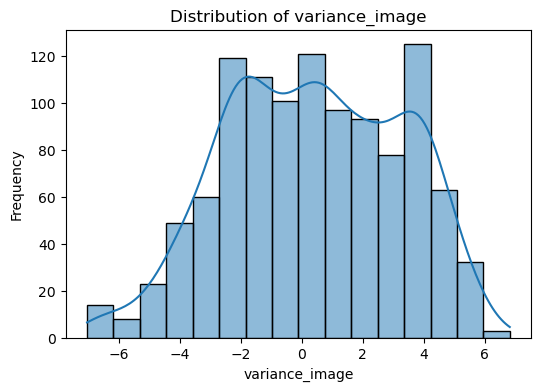

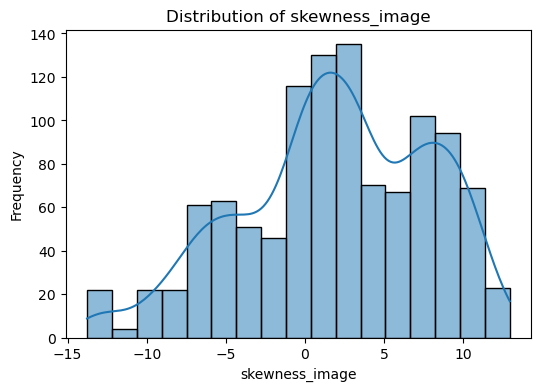

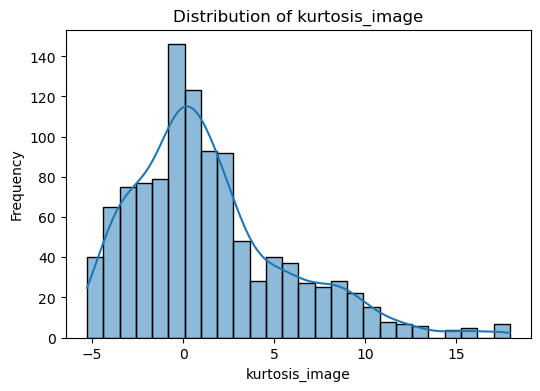

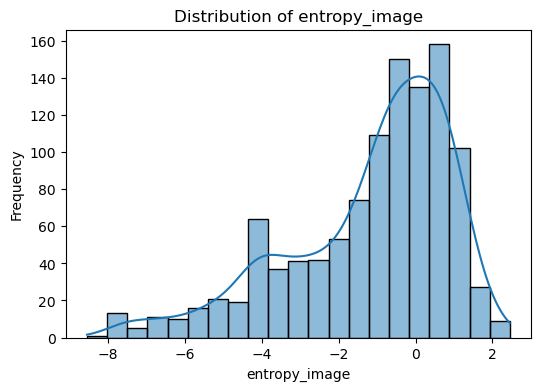

In [6]:
for column in X_train.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# all variables continuous

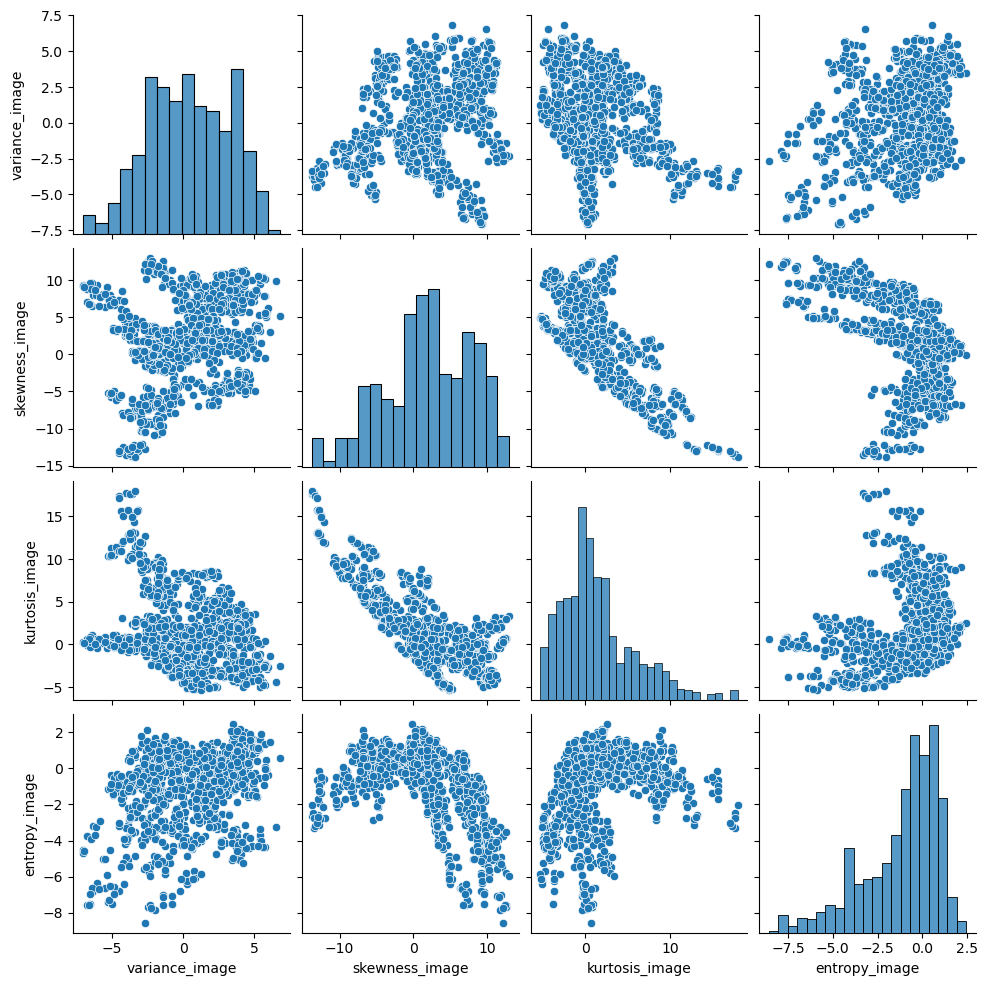

In [7]:
sns.pairplot(X_train)
plt.show()

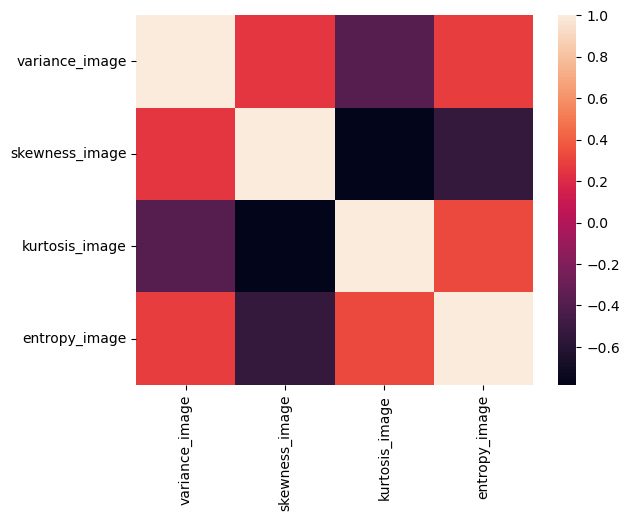

In [8]:
sns.heatmap(X_train.corr())
plt.show()

# can potentially drop one of kurtosis and skewness as they're strongly correlated

In [9]:
X_train.corr()

,variance_image,skewness_image,kurtosis_image,entropy_image
variance_image,1.000000,0.254668,-0.379601,0.278441
skewness_image,0.254668,1.000000,-0.782673,-0.536789
kurtosis_image,-0.379601,-0.782673,1.000000,0.321945
entropy_image,0.278441,-0.536789,0.321945,1.000000


- 'variance_image' has low to moderate correlation with other variables.
- 'skewness_image' has a strong negative correlation with kurtosis_image (-0.782673) and a moderate negative correlation with entropy_image (-0.536789).
- 'kurtosis_image' has a strong negative correlation with skewness_image and a moderate positive correlation with entropy_image (0.321945).
- 'entropy_image' has moderate correlations with all the other variables, none of which are very high.

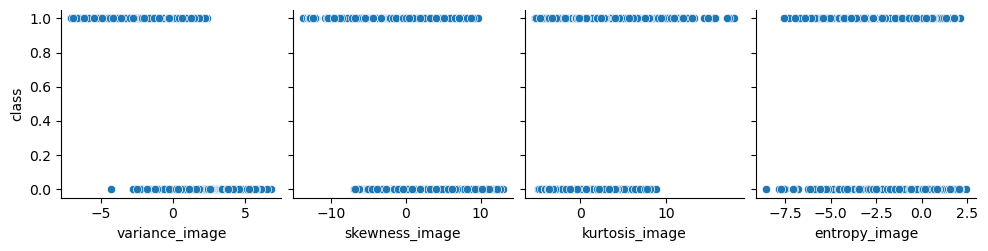

In [10]:
sns.pairplot(df, x_vars=X_train.columns, y_vars='class')
plt.show()

## Cross-validation

The next step is to use cross-validation to tune the hyperparameters of our classifier(s). For this assignment, we will use the `DecisionTreeClassifier` from `sklearn`.

It is standard procedure to perform feature scaling before training a model. This way, we can bring all the features to the same range and avoid having some features being more dominant than others.

For this assignment we will use Min-Max feature scaling. Basically, we will bring all the feature to a pre-defined scaled of a minimum and a maximum number. This range will be [0,1]

Use the `MinMaxScaler` utility to set the training set, `X_train`, to the range of [0,1]. Save the resulting array to the same variable name `X_train`. Please ensure that this variable is a `pd.DataFrame`.

*!!! It is important to use only the training set and not the entire dataset. That way we can avoid having any information of the testing set leaking to the trainig procedure*

*Hint: You will need to define and fit an instance of the `MinMaxScaler`. That will be useful for the next step where we will use that instance to perform feature scaling on evaluation set as well.*

In [11]:
# Add your code here
scaler = MinMaxScaler(feature_range=(0,1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train.head()


,variance_image,skewness_image,kurtosis_image,entropy_image
0,0.293930,0.128997,0.606117,0.585068
1,0.777196,0.874255,0.059573,0.472781
2,0.620557,0.548896,0.142844,0.836804
3,0.556936,0.602402,0.439167,0.827280
4,0.398020,0.272939,0.475710,0.856675


Use the instance of the `MinMaxScaler` that you defined in the previous step and perform scaling on the evaluation set as well. 

Scaling the evaluation set `X_eval`. Save the resulting array to the same variable `X_eval`. Please ensure that this variable is a `pd.DataFrame`.

In [12]:
# Add your code here
X_eval = pd.DataFrame(scaler.fit_transform(X_eval), columns=X_eval.columns, index=X_eval.index)
X_eval.head()

,variance_image,skewness_image,kurtosis_image,entropy_image
0,0.388118,0.425674,0.419778,0.826941
1,0.726778,0.639864,0.319241,0.825727
2,0.326225,0.651637,0.196041,0.667523
3,0.760792,0.726795,0.239944,0.677106
4,0.587475,0.614334,0.421209,0.854884


The next step is to tune the hyperparameters of our selected classifier. Each method (e.g Decision Trees, SVM, Logistic Regression etc) has its own set of hyperparameters that require tuning. Fine tuning is essential in order to adress possible under- or over-fitting issues. 

**2. K-Fold validation**

For this assignment, we will use k-fold validation on the training test, in order to pick the best set of parameters.
Use the `KFold` utility to define a k-fold object. Use a 5-fold validation approach. Save it to a variable called `cv_object`. For reproducability purposes, set `shuffle = True` and `random_state = 50`. 

In [13]:
# Add your code here
cv_object = KFold(
    n_splits=5,
    shuffle=True,
    random_state=50
)


**3. Hyperparameter tuning**

Define the values of the grid that is to be explored. To do this, create a variable called `grid_values`. This should be a dictionary where the keys are the names of the hyperparameters of the `DecisionTreeClassifier` and the values are lists that contain the desired hyperparameter values.

For this assignment, create a grid for the following hyperparameters:

`criterion`, `splitter`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, `max_features`

In [14]:
# Add your code here


# original search space
# grid_values = {
#     "criterion": ['gini', 'entropy', 'log_loss'],
#     "splitter": ['best', 'random'],
#     "max_depth": [3, 5, 7, 10],
#     "min_samples_split": [2, 5, 10, 20, 50],
#     "min_samples_leaf": [1, 2, 4, 6, 8, 12],
#     "max_leaf_nodes": [None, 5, 10, 20, 100], 
#     "max_features": [1, 2, 3, 'sqrt', 'log2', None]
# }

# `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. 
# To keep the past behaviour, explicitly set `max_features='sqrt'`

# result:
# best_params_
# {'criterion': 'entropy',
#  'max_depth': 10,
#  'max_features': 3,
#  'max_leaf_nodes': 100,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'splitter': 'random'}

# classfication report
#               precision    recall  f1-score   support

#            0       1.00      0.99      0.99       599
#            1       0.99      1.00      0.99       498

#     accuracy                           0.99      1097
#    macro avg       0.99      0.99      0.99      1097
# weighted avg       0.99      0.99      0.99      1097


In [ ]:
# second search space
grid_values = {
    "criterion": ['gini', 'entropy'],
    "splitter": ['best', 'random'],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "max_leaf_nodes": [None, 5, 10], 
    "max_features": [1, 2, 3, 'sqrt', 'log2', None]
}

# result:
# best_params_
# {'criterion': 'entropy',
#  'max_depth': 5,
#  'max_features': None,
#  'max_leaf_nodes': None,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'splitter': 'best'}

# classfication report
#               precision    recall  f1-score   support

#            0       0.99      1.00      0.99       599
#            1       1.00      0.98      0.99       498

#     accuracy                           0.99      1097
#    macro avg       0.99      0.99      0.99      1097
# weighted avg       0.99      0.99      0.99      1097

Having defined the values of the grid, it is now time to use `GridSearchCV`.

Define a grid search estimator and assign it to a variable called `grid_estimator`. Use `DecisionTreeClassifier` as a base estimator and set its `random_state = 10`. 

There is no need to define any hyperparameters, since we have already done that in the previous step (`grid_values`).

Use the `cv_object` from the previous step, and `accuracy` as a scoring metric.

In [15]:
# Add your code here
grid_estimator = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=10),
    param_grid=grid_values,
    cv=cv_object,
    scoring='accuracy'
)


## Training

**4. Training phase and identification of best hyperparameters**

Everything is in place. We can now train our model using the training set. Use the `.fit` method of the estimator you defined in the previous step. The result will be the best estimator based on the hyperparameter values we defined.

In [16]:
# Add your code here
grid_estimator.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=50, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5],
                         'max_features': [1, 2, 3, 'sqrt', 'log2', None],
                         'max_leaf_nodes': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

Once training is complete, uncomment and run the cell below to view the best parameters

In [17]:
grid_estimator.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

Uncomment the following code to plot the generated tree

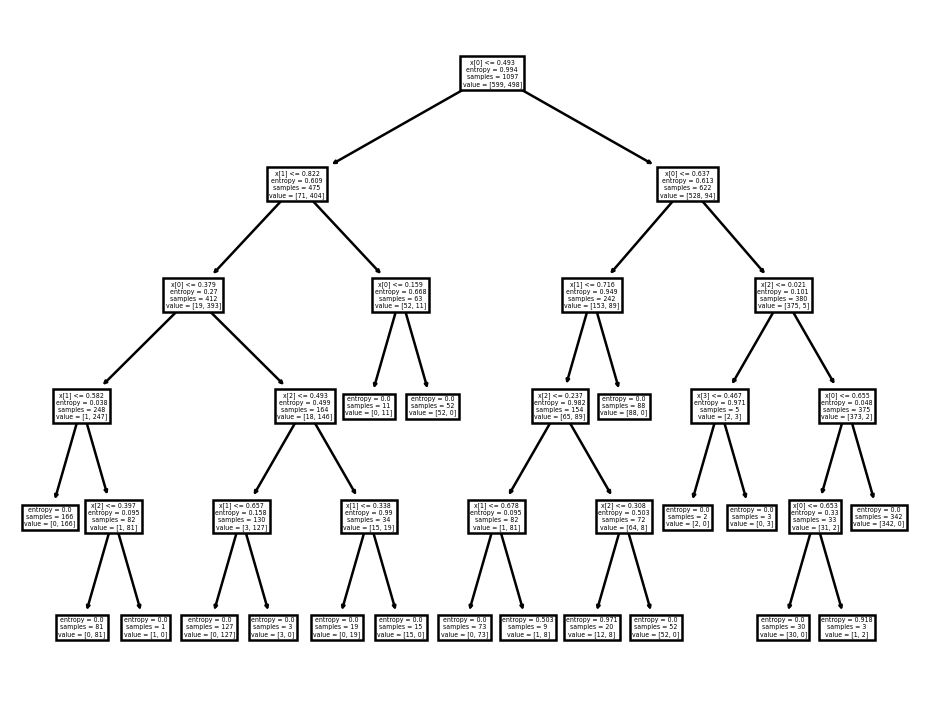

In [18]:
plt.figure(dpi=180)
plot_tree(grid_estimator.best_estimator_)
plt.show()

Now that we have trained our model, let's see how well it performs on the training data. 

Create a variable `y_pred` and store the predictions of the model for the training set:

In [19]:
# Add your code here
y_pred = grid_estimator.predict(X_train)


Calculate the accuracy of our model on the training set using the `accuracy_score` metric. Assign the result to a variable called `accuracy`. It should be a float number, rounded to two digits (e.g 0.85)

In [20]:
# Add your code here
accuracy = accuracy_score(y_train, y_pred)


Once complete, uncomment and run the cell below to print the metric.

In [21]:
print("Accuracy score metric on training: {}".format(accuracy))

Accuracy score metric on training: 0.9908842297174111


## Validation

**5. Validation step on the testing set**

We can now use this model to make predictions on new, previously unseen data. It is now time to use the testing set and validate the performance of our classifier to **KATE**.

Create a variable `y_eval_pred` and store the predictions of the model for the evaluation set. 

In [22]:
# Add your code here
y_eval_pred = grid_estimator.predict(X_eval)


In [23]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       599
           1       1.00      0.98      0.99       498

    accuracy                           0.99      1097
   macro avg       0.99      0.99      0.99      1097
weighted avg       0.99      0.99      0.99      1097



At this point, we trained a model. We have also generated predictions for data without labels (`y_eval_pred`). To see how well our model has performed on the test set, you will have to submit it to **KATE**!

**6. AUC and ROC**

The **AUC-ROC** is an important evaluation metric for checking any classification model's performance. It checks the performance of a classification model at various threshold settings.

For this assignment, you will construct the **ROC** curve and calculate the **AUC** of our classification model. In order to achieve that, the evaluation set will be used and calculate the probability estimates of the positive class. Luckily, `sklearn` includes this functionality for Decision Trees.

Create a variable `y_pred_proba` and calculate the probability estimates for the testing set.

In [24]:
# Add your code here
y_pred_proba = grid_estimator.predict_proba(X_train)[:, 1]


The next step is to calculate the *True Positive Rate* (TPR) and *False Positive Rate* (FPR) for various threshold values. Use the appropriate `sklearn` function and assign the results to variables named `fpr`, `tpr` and `thresholds` respictively.

Furthermore, calculate the auc metric and assign its value to variable `auc_metric`. It should be a float number, rounded to 3 digits.

In [25]:
# Add your code here
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
auc_metric = auc(fpr, tpr)


Uncomment the following cell and run the code to construct the ROC curve and see the AUC metric

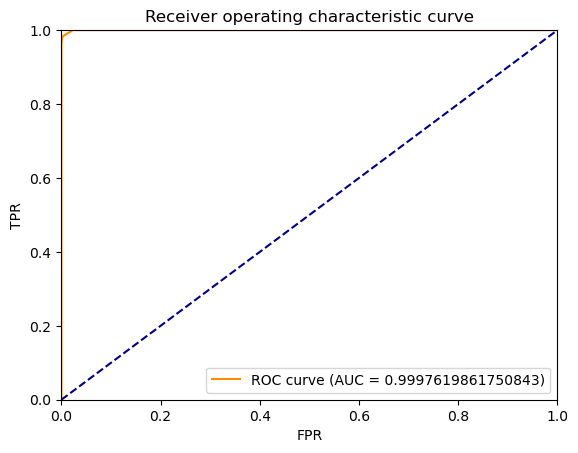

In [26]:
plt.figure(dpi=100)
plt.title("Receiver operating characteristic curve")
plt.plot(fpr,tpr, color='darkorange',label="ROC curve (AUC = {})".format(auc_metric))
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.ylim([0,1])
plt.xlim([0,1])
plt.show()